This notebook explores use of an RNN with the [EEG eye state dataset](https://archive.ics.uci.edu/ml/datasets/EEG+Eye+State).
> All data is from one continuous EEG measurement with the Emotiv EEG Neuroheadset. The duration of the measurement was 117 seconds. The eye state was detected via a camera during the EEG measurement and added later manually to the file after analysing the video frames. '1' indicates the eye-closed and '0' the eye-open state. All values are in chronological order with the first measured value at the top of the data.

As the data is provided in chronological order we can generate labeled sequences suitable for training an RNN.  We'll start by loading the data:

In [1]:
import numpy as np

# Load data file
# There are 19 rows of "header" material in our data file
rawdata = np.loadtxt('EEG_eye_state.txt', delimiter=',', skiprows=19, dtype=np.float32)

# Separate into X inputs and y labels
X_raw = rawdata[:,:-1]
y_raw = rawdata[:,-1]
print('Input consists of {} samples with {} dimensions.  Two samples follow:'.format(X_raw.shape[0], X_raw.shape[1]))
print(X_raw[:2])

Input consists of 14980 samples with 14 dimensions.  Two samples follow:
[[4329.23 4009.23 4289.23 4148.21 4350.26 4586.15 4096.92 4641.03 4222.05
  4238.46 4211.28 4280.51 4635.9  4393.85]
 [4324.62 4004.62 4293.85 4148.72 4342.05 4586.67 4097.44 4638.97 4210.77
  4226.67 4207.69 4279.49 4632.82 4384.1 ]]


Each sample consists of 14 features which are high value numbers which little change through the samples.   These changes are quite small objectively so, to accentuate the patterns present in the miniscule variations in the data we'll need to do some pre-processing so the variations become more pronounced and easier for our model to train on:

In [2]:
from sklearn.preprocessing import normalize, scale

# normalizing first, then scaling (not the reverse) has a significant effect in the ability for the model to converge
X_raw = normalize(X_raw, axis=0)
X_raw = scale(X_raw, axis=0)

print('After scaling and normalizing the data all features are in the range -1 to 1:')
print(X_raw[:2])

After scaling and normalizing the data all features are in the range -1 to 1:
[[ 0.00293431 -0.01170681  0.56740373 -0.00320852  0.24522723 -0.01978841
  -0.00293001  0.85256433  0.00150876  0.18774603  0.2335118   0.0307404
   0.01712686 -0.00383413]
 [ 0.0010844  -0.1120505   0.67139894 -0.00311072  0.00889115 -0.01961054
  -0.00281697  0.78225505 -0.00377129 -0.12210524  0.13849996  0.00619956
   0.01457776 -0.00548927]]


/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/data.py:164: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/data.py:181: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "


Now that our data has been pre-processed we need to convert the chronological list of single EEG observations into samples that consist of **sequences** of EEG observations.   We'll choose a `window_size` which indicates the length of the EEG sequence we want in each sample.   We'll take the first `window_size` EEG observations and turn them into a sequence.  The label for this sequence will be the label that applies to the final  EEG observation in the sequence.  

Our next sample will start with the 2nd EEG observation from the previous sample and add one new EEG observation.  The label for this next sample will be the label of the new EEG observation (last in the sequence) added for this sample.  We end up with `window_size` *fewer* samples because the first `window_size` - 1 observations are present in the first sample's sequence.

In [3]:
# transform from single labeled EEG reading in to labeled *sequences* of EEG readings
def ordered_samples_to_sequence_samples(samples, labels, window_size):
    seq_labels = labels[window_size:]
    seq_samples = []
    for sample_idx in range(window_size, len(samples)):
        seq_samples.append(samples[sample_idx - window_size:sample_idx])
            
    return (np.array(seq_samples), np.array(seq_labels))
       
window_size = 10
X, y = ordered_samples_to_sequence_samples(X_raw, y_raw, window_size)

print(X.shape)


(14970, 10, 14)


Next we use the `train_test_split` function to divide into train and test datasets.

In [4]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

print(X_train.shape)


(11227, 10, 14)


In [5]:
from keras.models import Sequential
from keras.layers import GRU, Dense, Activation, Flatten
from keras import optimizers


# create and fit the LSTM network
model = Sequential()
model.add(GRU(196, dropout=0.2, recurrent_dropout=0.2, input_shape=X_train.shape[1:])) # input shape is the 2nd and 3rd dim of data
model.add(Dense(1, activation='sigmoid'))

# try using different optimizers and different optimizer configs
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.Adam(lr=0.003), # optimizers.Adam(lr=0.003)
              metrics=['accuracy'])
print(model.summary())

/opt/conda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_1 (GRU)                  (None, 196)               124068    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 197       
Total params: 124,265
Trainable params: 124,265
Non-trainable params: 0
_________________________________________________________________
None


In [9]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

# checkpoint
filepath="rnn-weights.hdf5" # "weights-{epoch:02d}-{val_acc:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

# early stopping
early_stop = EarlyStopping(monitor='val_acc', min_delta=0, patience=3, verbose=0, mode='auto')

# train the model
history = model.fit(X_train, 
                    y_train, 
                    validation_split=0.2, 
                    epochs=50, 
                    batch_size=32, 
                    verbose=1, 
                    callbacks=[checkpoint, early_stop])

Train on 8981 samples, validate on 2246 samples
Epoch 1/50
8981/8981 [==============================] - 6s 710us/step - loss: 0.3127 - acc: 0.8635 - val_loss: 0.2198 - val_acc: 0.9114
Epoch 2/50
8981/8981 [==============================] - 6s 704us/step - loss: 0.3131 - acc: 0.8648 - val_loss: 0.2058 - val_acc: 0.9261
Epoch 3/50
8981/8981 [==============================] - 6s 705us/step - loss: 0.3063 - acc: 0.8684 - val_loss: 0.1902 - val_acc: 0.9350
Epoch 4/50
8981/8981 [==============================] - 8s 848us/step - loss: 0.2967 - acc: 0.8766 - val_loss: 0.1911 - val_acc: 0.9337
Epoch 5/50
8981/8981 [==============================] - 8s 860us/step - loss: 0.3004 - acc: 0.8737 - val_loss: 0.1837 - val_acc: 0.9305
Epoch 6/50
8981/8981 [==============================] - 7s 800us/step - loss: 0.2927 - acc: 0.8733 - val_loss: 0.1680 - val_acc: 0.9372
Epoch 7/50
8981/8981 [==============================] - 7s 753us/step - loss: 0.2903 - acc: 0.8755 - val_loss: 0.2041 - val_acc: 0.9248


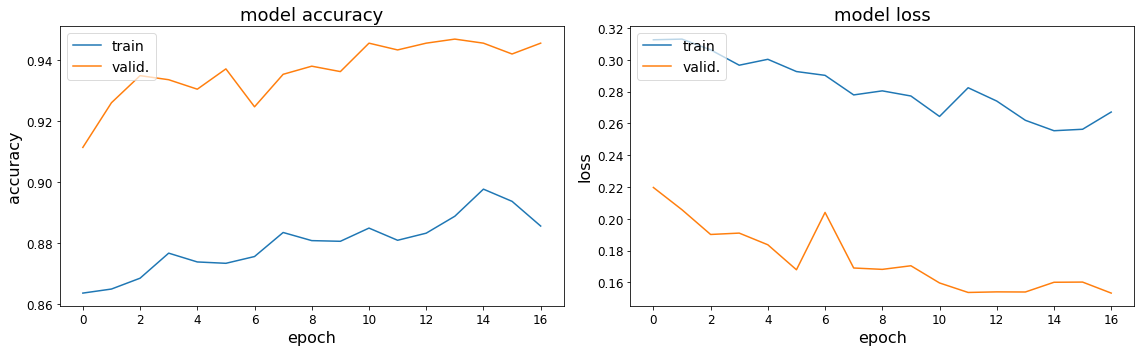

In [12]:
%matplotlib inline
import plot_util as plots

plots.plot_history(history)

In [13]:
score, acc = model.evaluate(X_test, y_test,
                            batch_size=32)
print('Test score:', score)
print('Test accuracy:', acc)

3743/3743 [==============================] - 1s 217us/step
Test score: 0.14735308413936465
Test accuracy: 0.9503072401975967


In [ ]:
TODO: setup callbacks - https://keras.io/callbacks/